In [14]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss
from collections import Counter
import string
import re

# Import user defined functions.
import parse as prs
import helper as hlp

# Read and parse json.
df = pd.read_json('data/train.json')

# Defining names of the target
target_names = ['high','medium','low']

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
# Reducing the dataframe
#rows = np.random.choice(df.index.values, 1000)
#sampled_df = df.ix[rows]
#df = sampled_df

In [3]:
# Looking at the dataframe
rows = np.random.choice(df.index.values, 3)
sampled_df = df.ix[rows]
sampled_df

,bathrooms,bedrooms,building_id,created,description,display_address,features,interest_level,latitude,listing_id,longitude,manager_id,photos,price,street_address
108685,1.0,0,f646d99f9e9013f21384e1b64cfe02e1,2016-04-15 04:23:38,Experience all the beautiful historic charm of...,Greenwich Avenue,"[Loft, Laundry in Building, Hardwood Floors]",low,40.7383,6877404,-74.0019,35af1611db6bc8ffe0488799a5bc97d3,[https://photos.renthop.com/2/6877404_a5306b47...,3150,106 Greenwich Avenue
25157,1.0,1,300c5229c48b49cd3c8cf80fe61b853b,2016-06-28 03:11:26,THIS IS A MUST!PRIME LOCATION IN GRAMERCY!NEXT...,E 19th St.,"[Doorman, Elevator, Laundry in Building, Dishw...",low,40.7356,7224506,-73.9828,e6472c7237327dd3903b3d6f6a94515a,[https://photos.renthop.com/2/7224506_d18272e0...,3700,245 E 19th St.
13872,1.0,1,657c5f41c182481f28907360aea56d10,2016-06-22 04:10:31,Boutique Building in Magnificent River...,Netherland Ave,[],low,40.8866,7199151,-73.9103,118d149b0808ed10b770005944c87c94,[https://photos.renthop.com/2/7199151_cc46f39e...,1795,3590 Netherland Ave


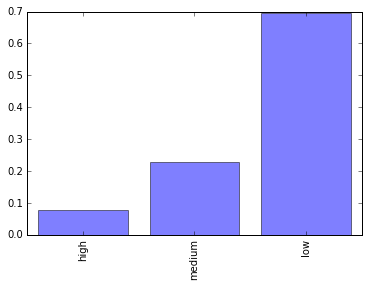

In [4]:
# Proportion of interest level.
prop_interest = []
for interest_name in target_names:
   prop_interest.append(np.float(np.sum(df.interest_level==interest_name))/np.float(np.shape(df)[0]))

# Plotting as graph bar.
y_pos = np.arange(len(target_names))
plt.bar(y_pos, prop_interest, align='center', alpha=0.5)
plt.xticks(y_pos, target_names, rotation='vertical') 
plt.show()

In [5]:
# Looking at the most common features in an subset
size_subset = 100
n_features = 10
rows = np.random.choice(df.index.values, size_subset)
sampled_features = df["features"].ix[rows]
allFeatures=[]
for row in rows:
    allFeatures.extend(sampled_features.loc[[row]].values[0])
     #   allFeatures.extend(map(lambda x:x.lower(),sampled_features.loc[[row]].values[0]))
features_to_count = (word for word in allFeatures if word[:1])
features_count = Counter(features_to_count)
common_features = map(lambda x:x[0],features_count.most_common(n_features))
common_features_rows= map(lambda x:'with_'+x.lower().replace(" ","_"),common_features)
print(common_features_rows)

[u'with_hardwood_floors', u'with_elevator', u'with_dishwasher', u'with_cats_allowed', u'with_dogs_allowed', u'with_doorman', u'with_no_fee', u'with_fitness_center', u'with_laundry_in_building', u'with_laundry_in_unit']


In [6]:
# Looking at the most common words in description in an subset
size_subset = 1000
n_keywords = 50
rows = np.random.choice(df.index.values, size_subset)
sampled_descriptions = df["description"].ix[rows]
allDescriptionsKeywords=[]
for row in rows:
    desc = sampled_descriptions.loc[[row]].values[0]

    #Add space before upper-case
    desc = re.sub(r'(?<=[a-z])(?=[A-Z])', ' ',desc)

    #Replace char with space
    repls = (',', ' '), ('#', ' '), ('.', ' '), ('-', ' '), ('\'', ' '), ('!', ' ')
    desc = reduce(lambda a, kv: a.replace(*kv), repls, desc.lower())

    #Remove all non letters 
    whitelist = set(string.letters+' ,')
    desc = ''.join(filter(whitelist.__contains__,desc))

    #Remove small words
    desc = ' '.join(word for word in desc.split() if len(word)>4)

    allDescriptionsKeywords.extend(desc.split(' '))

keywords_to_count = (word for word in allDescriptionsKeywords if word[:1])

keywords_count = Counter(keywords_to_count)
common_keywords = map(lambda x:x[0],keywords_count.most_common(n_keywords))

print(common_keywords)

[u'apartment', u'building', u'websiteredacted', u'kitchen', u'bedroom', u'appliances', u'floors', u'space', u'kagglemanagerrenthop', u'stainless', u'renovated', u'hardwood', u'laundry', u'steel', u'large', u'features', u'located', u'email', u'great', u'bathroom', u'marble', u'contact', u'doorman', u'windows', u'living', u'closet', u'floor', u'granite', u'private', u'luxury', u'restaurants', u'center', u'views', u'beautiful', u'location', u'dishwasher', u'ceilings', u'spacious', u'amenities', u'cooper', u'fitness', u'elevator', u'studio', u'access', u'viewing', u'broker', u'amazing', u'available', u'storage', u'estate']


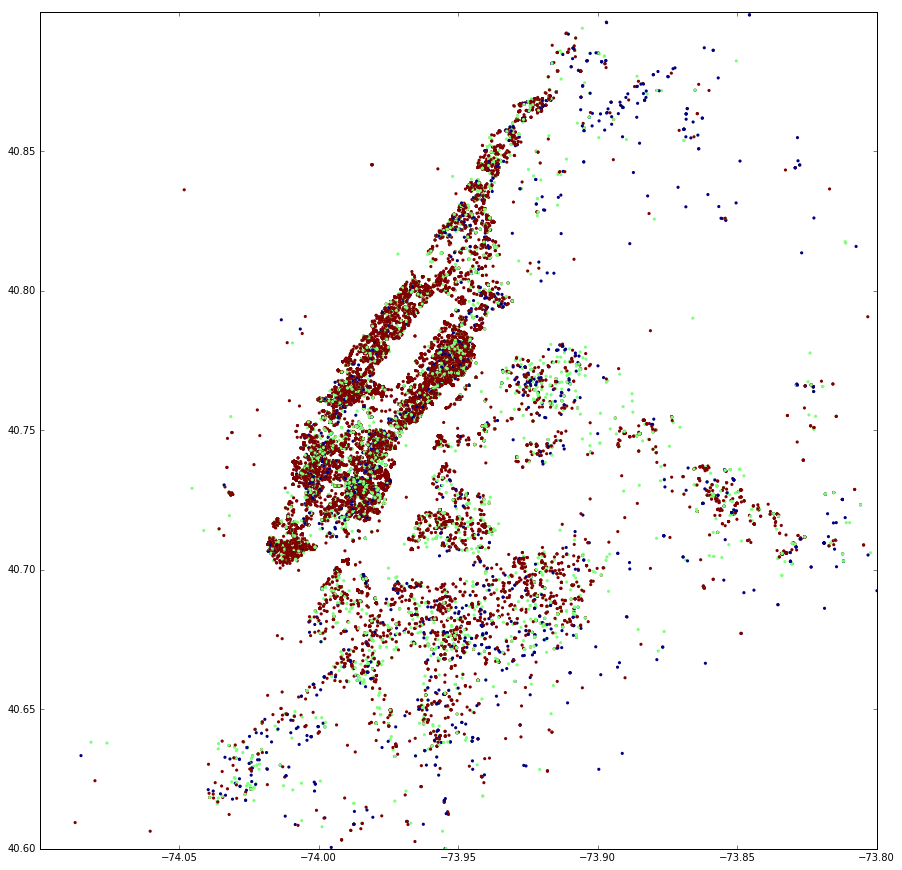

In [47]:
# Looking at the position vs interest

df_sample = pd.DataFrame(df, columns=["longitude","latitude","interest_level"])
df_sample["interest_level_num"] = map(lambda x:hlp.interest_level2numeral(x),df_sample["interest_level"])

# scatter plot position 2D vs interest lvl.
plt.figure(figsize=(15, 15))
plt.scatter(df_sample["longitude"].values,
            df_sample["latitude"].values,
            c=df_sample["interest_level_num"].values, marker='o', s=10,linewidths=0)
plt.xlim([-74.1, -73.8])
plt.ylim([40.6,40.9])
plt.show() 

In [7]:
# Parsing the dataframe
X, y = prs.parse_2(df.copy()),prs.target(df)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.33)

In [8]:
# Classifying
clf = RandomForestClassifier(n_estimators=500,n_jobs = 3)
clf = clf.fit(X_train, y_train)

In [9]:
# Estimating the score
y_val_pred = clf.predict_proba(X_val)
val_loss = log_loss(y_val,y_val_pred)
print(val_loss)

0.622395952478


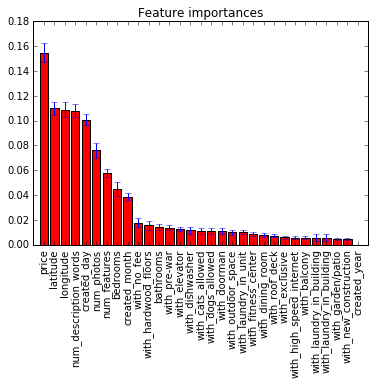

In [22]:
# Analyzing the forest features importance
importances = clf.feature_importances_
std = np.std([tree.feature_importances_ for tree in clf.estimators_],axis=0)
indices = np.argsort(importances)[::-1]

# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(X_train.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(X_train.shape[1]),X_train.columns.values[indices], rotation='vertical')
plt.xlim([-1, X_train.shape[1]])
plt.show()

In [ ]:
# Predicting data.
df_test = pd.read_json('data/test.json')
X_test = prs.parse_2(df_test.copy())
y_test_pred = clf.predict_proba(X_test)
ids = df_test['listing_id'].values

In [ ]:
# Writting the submission file
labels2idx = {label: i for i, label in enumerate(clf.classes_)}
subm = pd.DataFrame()
subm["listing_id"] = df_test["listing_id"]
for label in ["high", "medium", "low"]:
    subm[label] = y_test_pred[:, labels2idx[label]]
subm.to_csv("submission.csv", index=False)